# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from utils import *

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Load data & Basic information

In [2]:
credit = load_data('dseb63_credit_card_balance.csv', 
                   filename_train='dseb63_application_train.csv',
                   filename_test='dseb63_application_test.csv',
                   verbose=3)

Table: dseb63_credit_card_balance.csv
Shape: (3227965, 23)

Number of categorical variables: 1
Number of numerical variables: 22

Number of unique values of SK_ID_CURR: 86905
Number of unique values of SK_ID_PREV: 87452

Number of duplicate values: 0

Shape of train set: (246009, 123)
Number of overlapping SK_ID_CURR in dseb63_credit_card_balance.csv and dseb63_application_train.csv: 69536

Shape of test set: (61502, 122)
Number of overlapping SK_ID_CURR in dseb63_credit_card_balance.csv and dseb63_application_test.csv: 17369


,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR,TARGET
0,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.0,2250.0,...,1.0,1,0.0,0.0,69.0,Active,0,0,87788,1.0
1,2582071,-82,16809.210,67500,0.0,0.0,0.0,0.0,3375.0,9000.0,...,0.0,0,0.0,0.0,18.0,Active,0,0,87788,1.0
2,2582071,-84,27577.890,67500,0.0,0.0,0.0,0.0,3375.0,4500.0,...,0.0,0,0.0,0.0,16.0,Active,0,0,87788,1.0
3,2582071,-7,65159.235,45000,0.0,0.0,0.0,0.0,2250.0,2250.0,...,0.0,0,0.0,0.0,63.0,Active,0,0,87788,1.0
4,2582071,-59,70475.850,67500,24750.0,24750.0,0.0,0.0,3375.0,4500.0,...,4.0,4,0.0,0.0,41.0,Active,0,0,87788,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227965 entries, 0 to 3227964
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   SK_ID_PREV                  3227965 non-null  int64  
 1   MONTHS_BALANCE              3227965 non-null  int64  
 2   AMT_BALANCE                 3227965 non-null  float64
 3   AMT_CREDIT_LIMIT_ACTUAL     3227965 non-null  int64  
 4   AMT_DRAWINGS_ATM_CURRENT    2622211 non-null  float64
 5   AMT_DRAWINGS_CURRENT        3227965 non-null  float64
 6   AMT_DRAWINGS_OTHER_CURRENT  2622211 non-null  float64
 7   AMT_DRAWINGS_POS_CURRENT    2622211 non-null  float64
 8   AMT_INST_MIN_REGULARITY     2963581 non-null  float64
 9   AMT_PAYMENT_CURRENT         2607872 non-null  float64
 10  AMT_PAYMENT_TOTAL_CURRENT   3227965 non-null  float64
 11  AMT_RECEIVABLE_PRINCIPAL    3227965 non-null  float64
 12  AMT_RECIVABLE               3227965 non-null  float64
 1

### Observation
- Since the number of unique values of SK_ID_CURR is 86905 and the number of unique values of SK_ID_PREV is 87452, most of the applicants had just 1 credit card with them, and only a few of them had more than 1. 
- There are 69536 over 246009 applicants in the train set and 17369 over 61502 applicants in the test set having a credit card previously with Home Credit Group
- There are 23 numerical and 1 categorical columns

# 3. Target column

In [3]:
credit.TARGET.value_counts(dropna=False)

TARGET
0.0    2400480
NaN     640453
1.0     187032
Name: count, dtype: int64

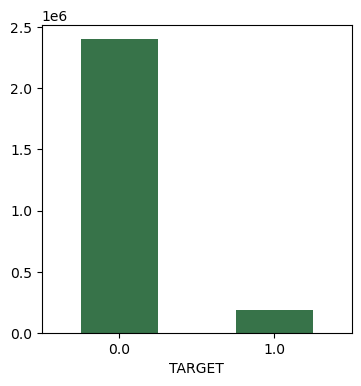

In [4]:
credit.TARGET.value_counts().plot.bar(color='#377349', figsize=(4,4), rot=0);

### Observation
- Most of the loans were paid back on time
- There are 640453 records not having TARGET

# 4. Missing values

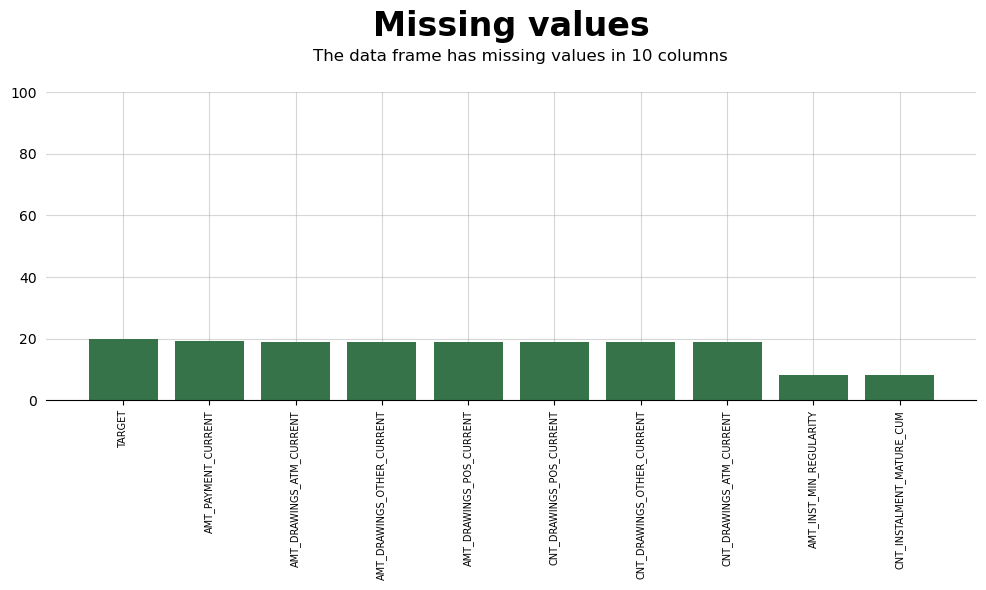

In [5]:
df_missing = create_df_missing(credit)
plot_df_missing(df_missing, x_title=0.5, x_subtitle=2.2)

### Observation
- Out of the 24 columns, 10 of them contain some NaN values, and their percentage of missing values is less than 20%.
- 8 of these features have close to 20% NaN values. These features except TARGET relate to the amounts of drawings, counts of drawings, and installment statistics.

# 5. Define numeric and category features

In [6]:
credit, cate_credit, num_credit = validate_dtype(credit)

# 6. Imbalanced class

In [7]:
cate_credit.NAME_CONTRACT_STATUS.value_counts(normalize=True)

NAME_CONTRACT_STATUS
Active           0.965523
Completed        0.030989
Signed           0.003079
Demand           0.000261
Sent proposal    0.000143
Refused          0.000004
Approved         0.000002
Name: proportion, dtype: float64

### Observation
- The "Active" class dominates the dataset, accounting for approximately 96.55% of the observations.
- The class distribution is imbalanced, as there is a significant class imbalance present.

# 7. Outlier

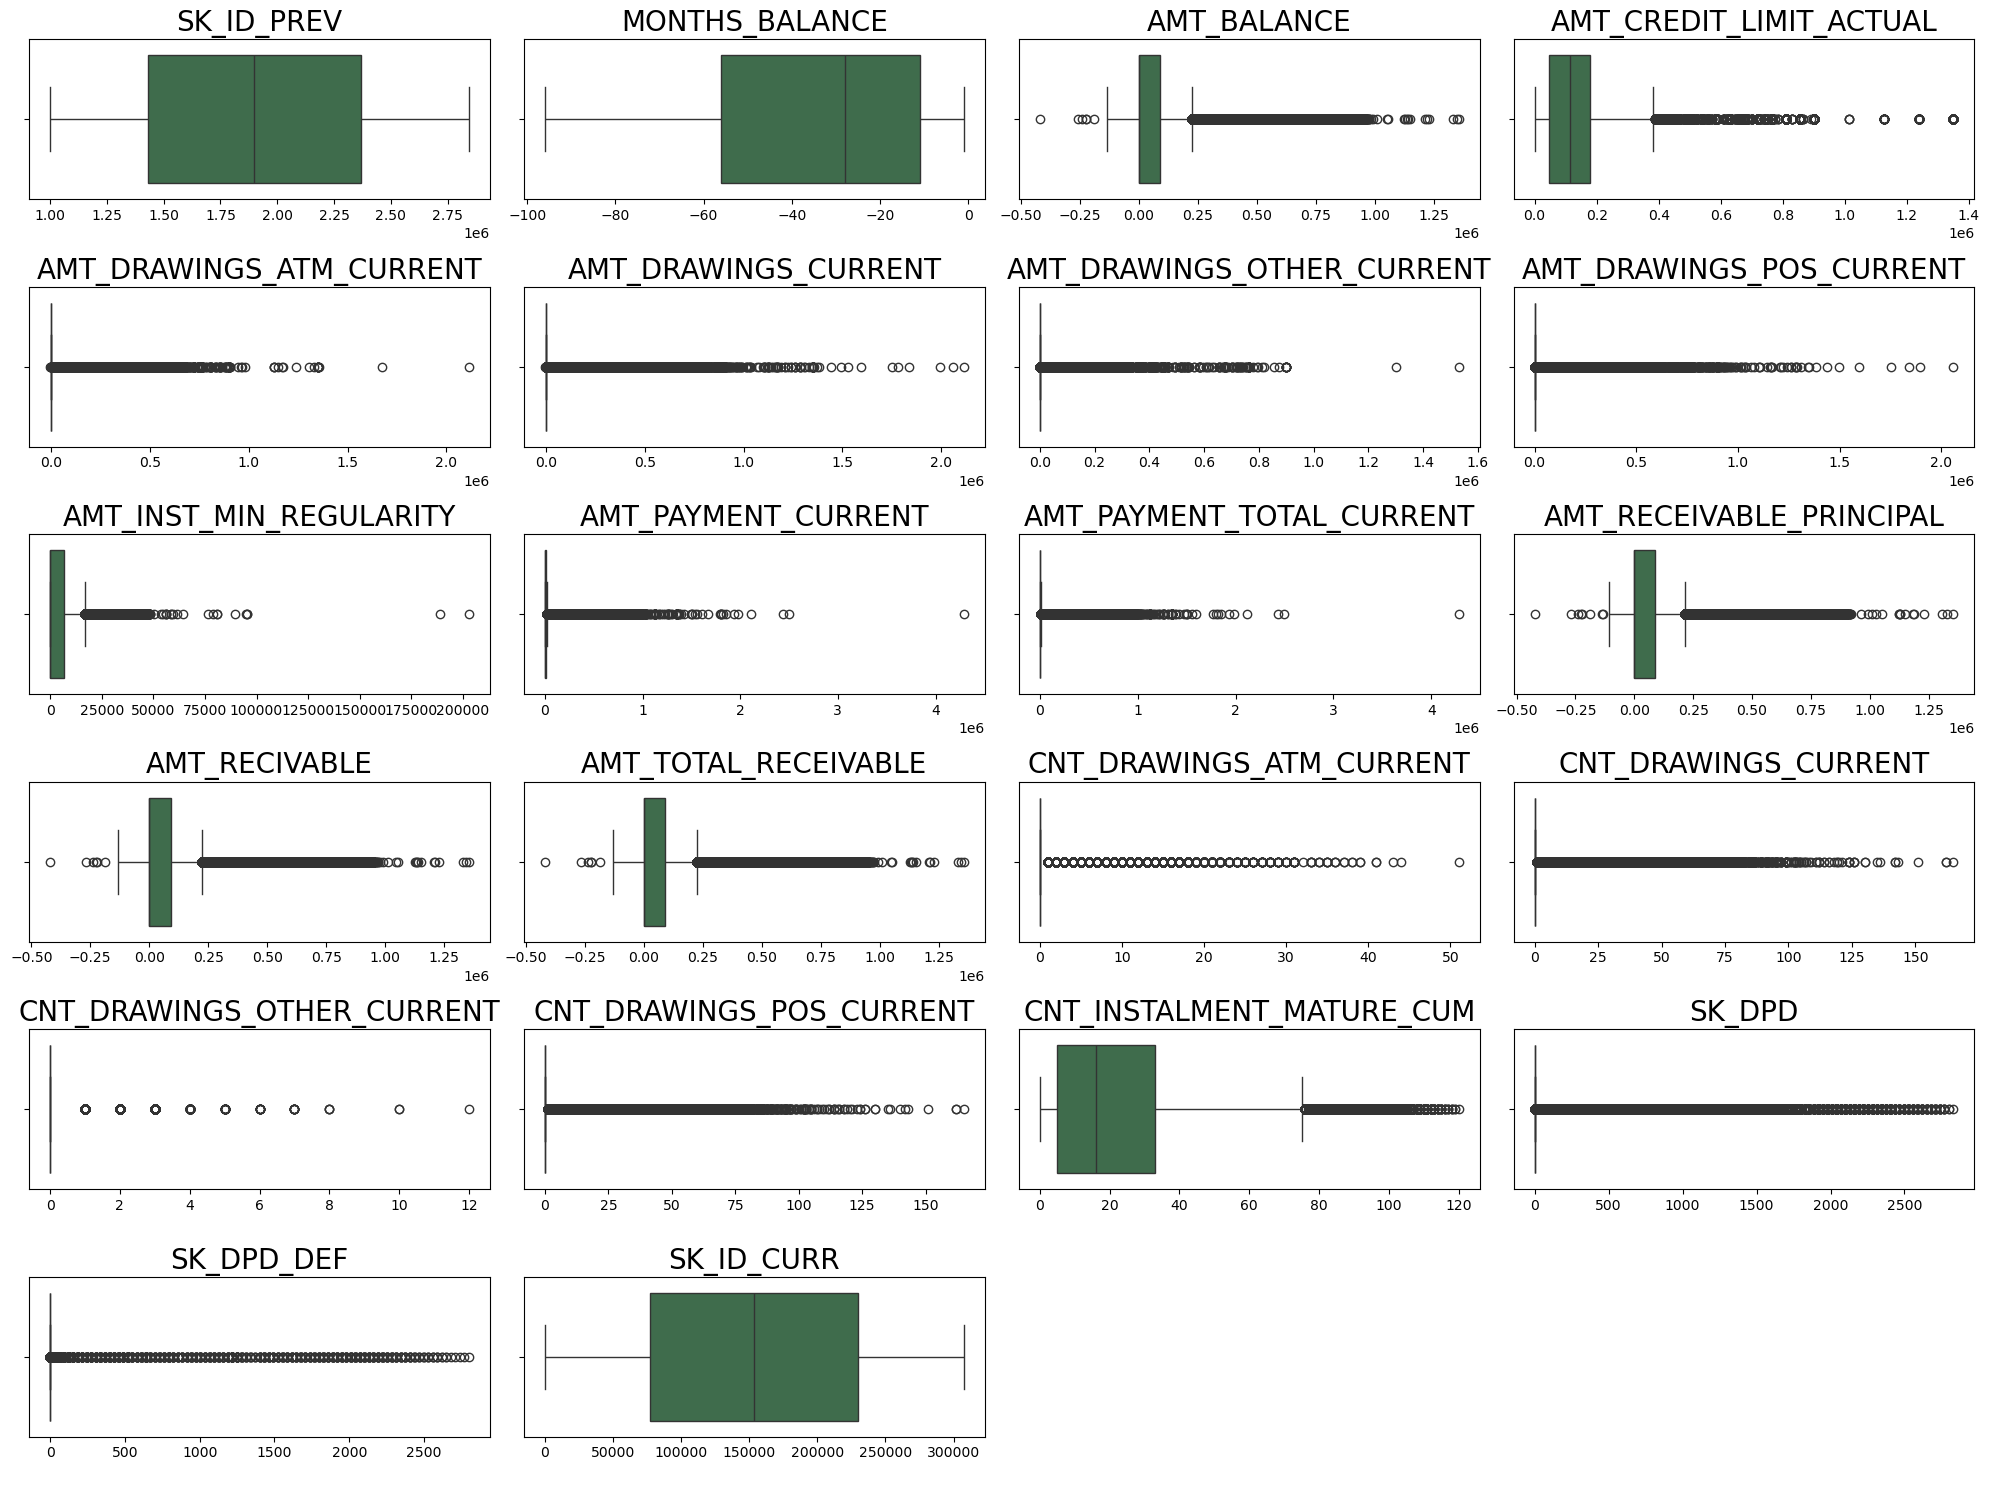

In [8]:
plot_boxplot(num_credit, figsize=(20, 15))

### Observation
Most features have many outliers and skewed distributions

# 8. Anomalies
There is no anomaly in this data

# 9. Correlation

In [9]:
cmat = CorrelationMatrix(credit, drop_cols=['SK_ID_CURR', 'SK_ID_PREV'])

In [10]:
cmat.target_top()

,PhiK-Correlation
AMT_PAYMENT_CURRENT,0.587338
AMT_RECIVABLE,0.461322
AMT_TOTAL_RECEIVABLE,0.461302
AMT_RECEIVABLE_PRINCIPAL,0.425183
AMT_BALANCE,0.420729
AMT_INST_MIN_REGULARITY,0.303511
AMT_PAYMENT_TOTAL_CURRENT,0.276265
AMT_DRAWINGS_CURRENT,0.204230
AMT_DRAWINGS_POS_CURRENT,0.201288
CNT_DRAWINGS_CURRENT,0.060081


## Numerical values

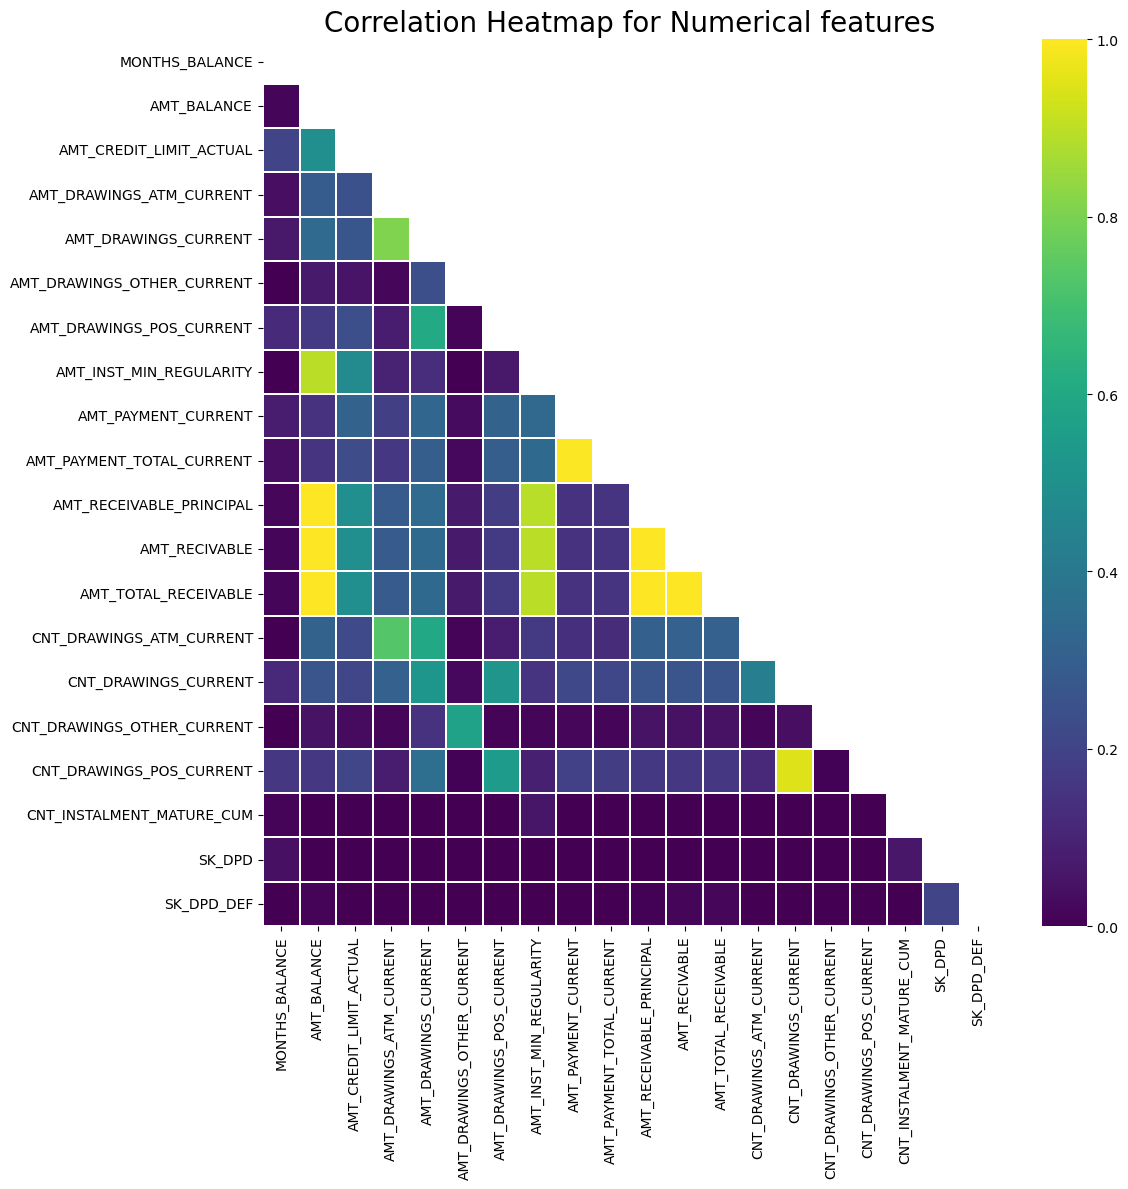

In [11]:
cmat.plot_correlation_matrix()

In [12]:
cmat.target_top_num()

,Correlation
AMT_BALANCE,0.048949
AMT_TOTAL_RECEIVABLE,0.048714
AMT_RECIVABLE,0.048667
AMT_RECEIVABLE_PRINCIPAL,0.048519
AMT_INST_MIN_REGULARITY,0.038444
CNT_DRAWINGS_CURRENT,0.038134
CNT_DRAWINGS_ATM_CURRENT,0.037370
MONTHS_BALANCE,0.034492
CNT_DRAWINGS_POS_CURRENT,0.030193
AMT_DRAWINGS_ATM_CURRENT,0.023930


### Observation
- Some of the highly correlated numeric pairs/groups are
    - AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE, AMT_BALANCE, and AMT_INST_MIN_REGULARITY
    - AMT_PAYMENT_CURRENT and AMT_PAYMENT_TOTAL_CURRENT
    - CNT_DRAWINGS_POS_CURRENT and CNT_DRAWINGS_CURRENT
- The correlation of features with TARGET is low. Therefore, there is no linear relationship between features and the target variable.

# 10. Categorical analysis

## NAME_CONTRACT_STATUS

Total Number of unique categories of NAME_CONTRACT_STATUS = 7


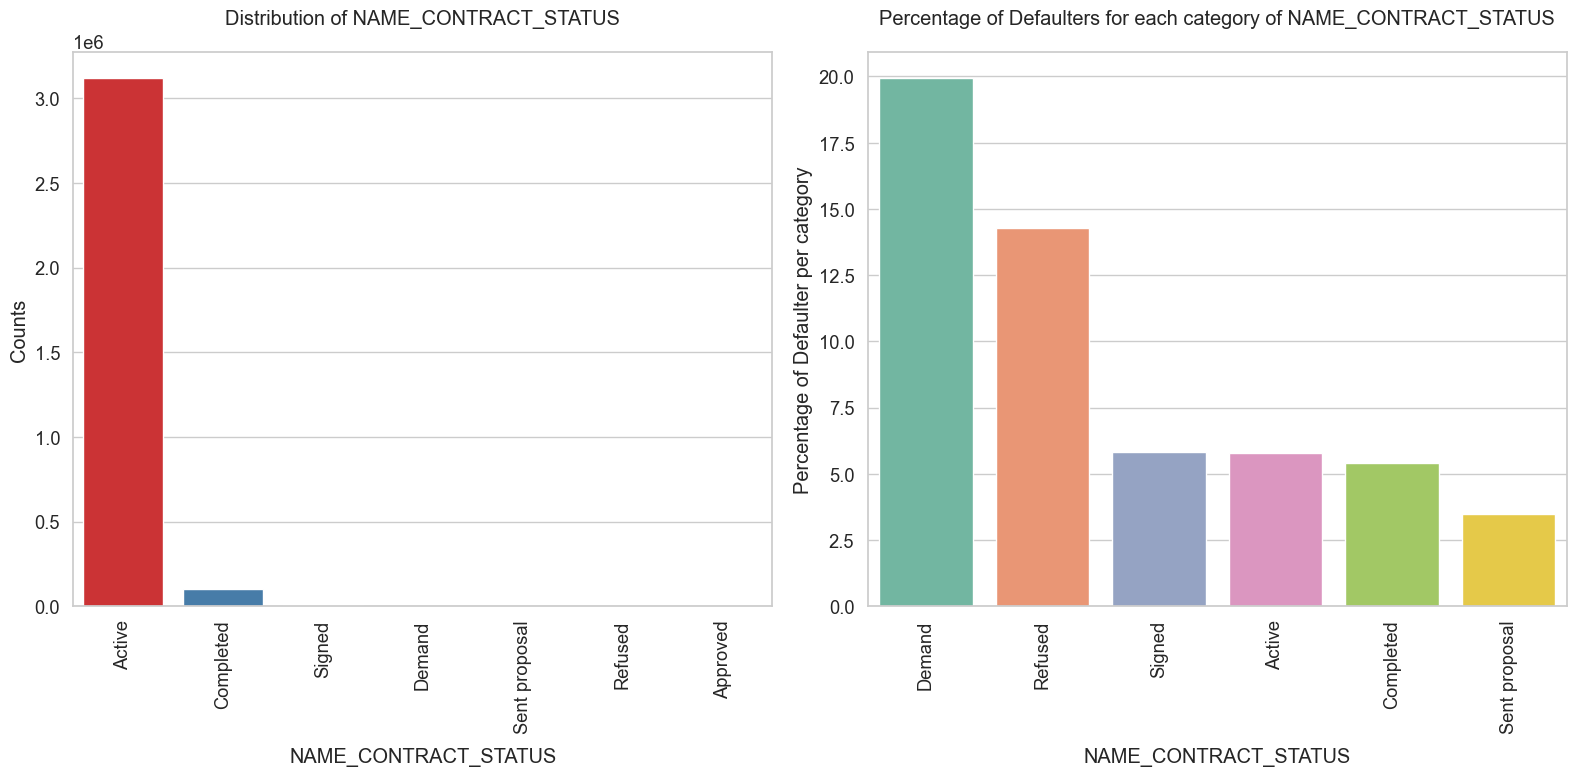

In [13]:
plot_categorical_variables_bar(credit, 'NAME_CONTRACT_STATUS')

### Observation
- From the first plot we see that most of the contract status is 'Active'
- From the second plot, we notice that the contracts belonging to 'Demand' and 'Refused' have the highest defaulting tendency as compared to the rest. They are followed by names of contract status: 'Signed', 'Active', 'Completed', and 'Sent proposal'

# 11. Numerical analysis
We will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loans that the client had.

In [14]:
credit_mean = credit.drop('NAME_CONTRACT_STATUS', axis=1).groupby('SK_ID_PREV').mean()

## 11.1 AMT_BALANCE

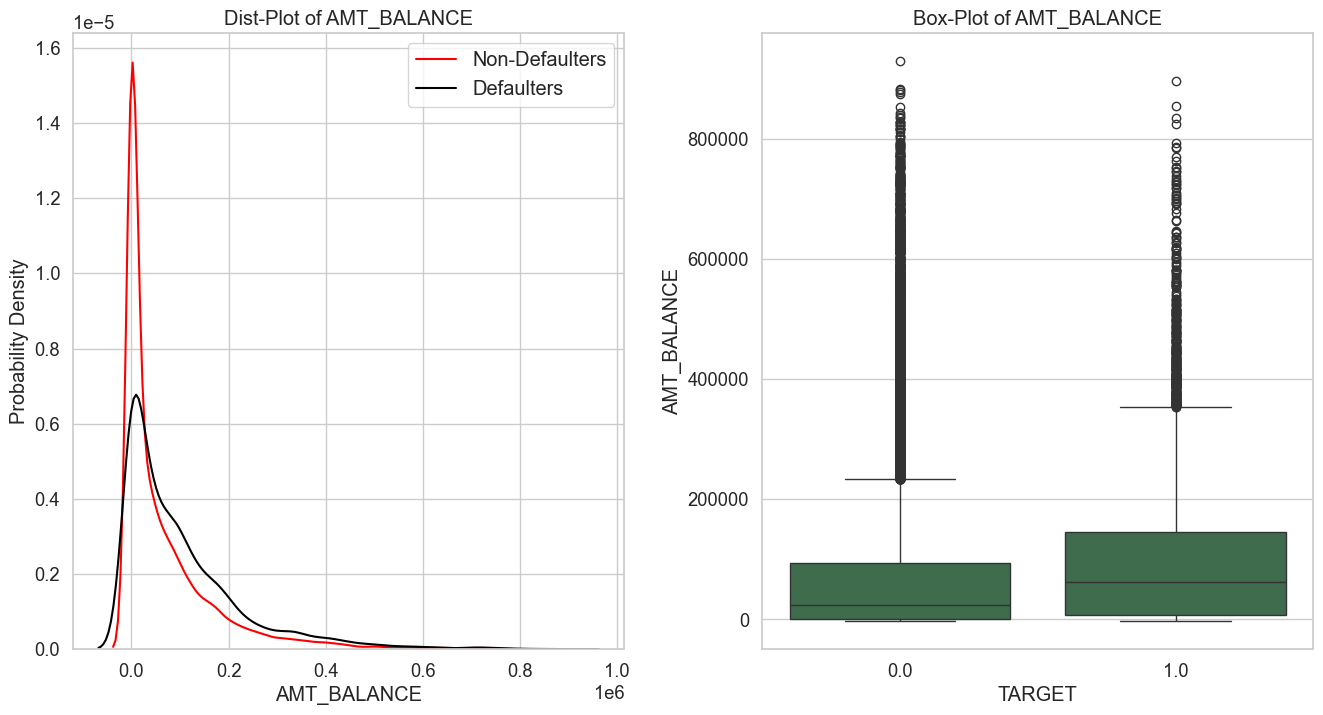

In [15]:
plot_continuous_variables(credit_mean, 'AMT_BALANCE', plots=['distplot', 'box'], figsize=(16, 8))

### Observation
- Defaulters show higher values of all the quantiles compared to non-defaulters.
- The PDF also shows a very higher peak at lower amounts for non-defaulters as compared to defaulters.

Therefore, we could conclude that  the credit amount for defaulters could be relatively higher than non-defaulters

## 11.2 AMT_TOTAL_RECEIVABLE

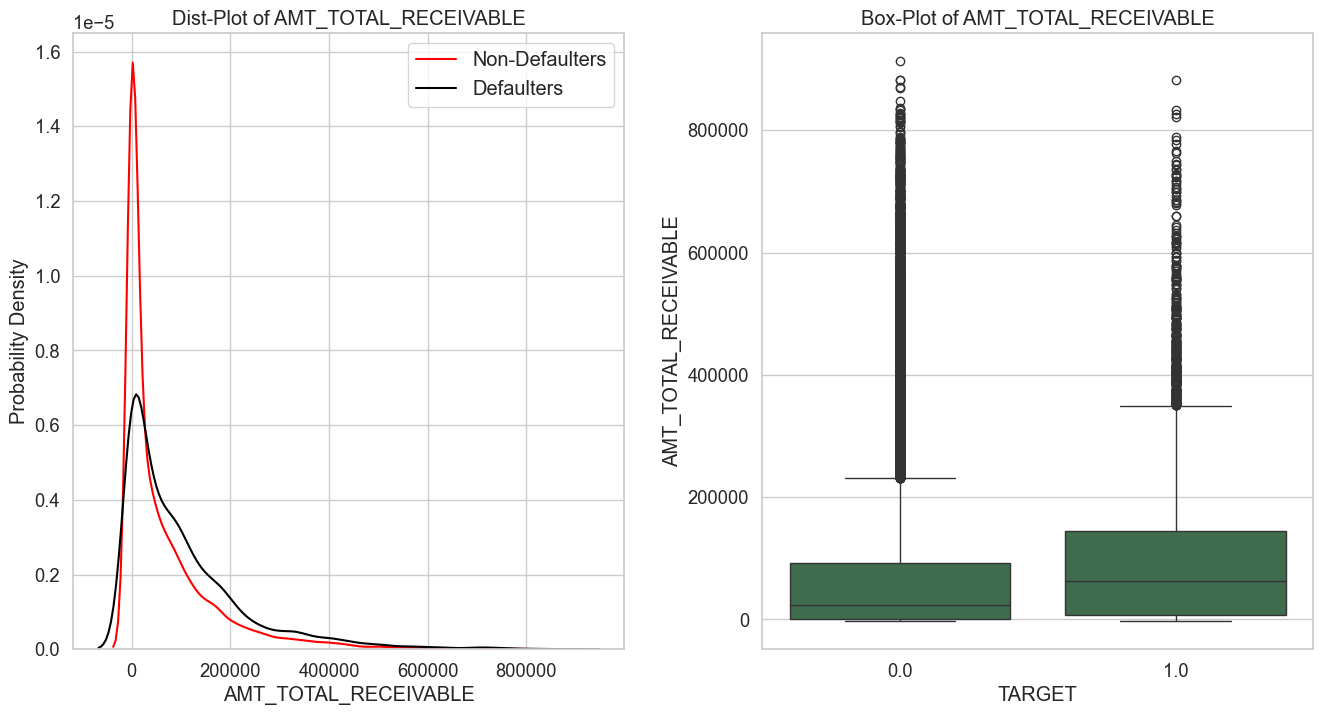

In [16]:
plot_continuous_variables(credit_mean, 'AMT_TOTAL_RECEIVABLE', plots=['distplot', 'box'], figsize=(16, 8))

### Observation
- Defaulters show higher values of all the quantiles compared to non-defaulters.
- The PDF also shows a very higher peak at lower amounts for non-defaulters as compared to defaulters.

Therefore, we could conclude that the receivable amount for defaulters could be relatively higher than non-defaulters

## 10.3 AMT_INST_MIN_REGULARITY

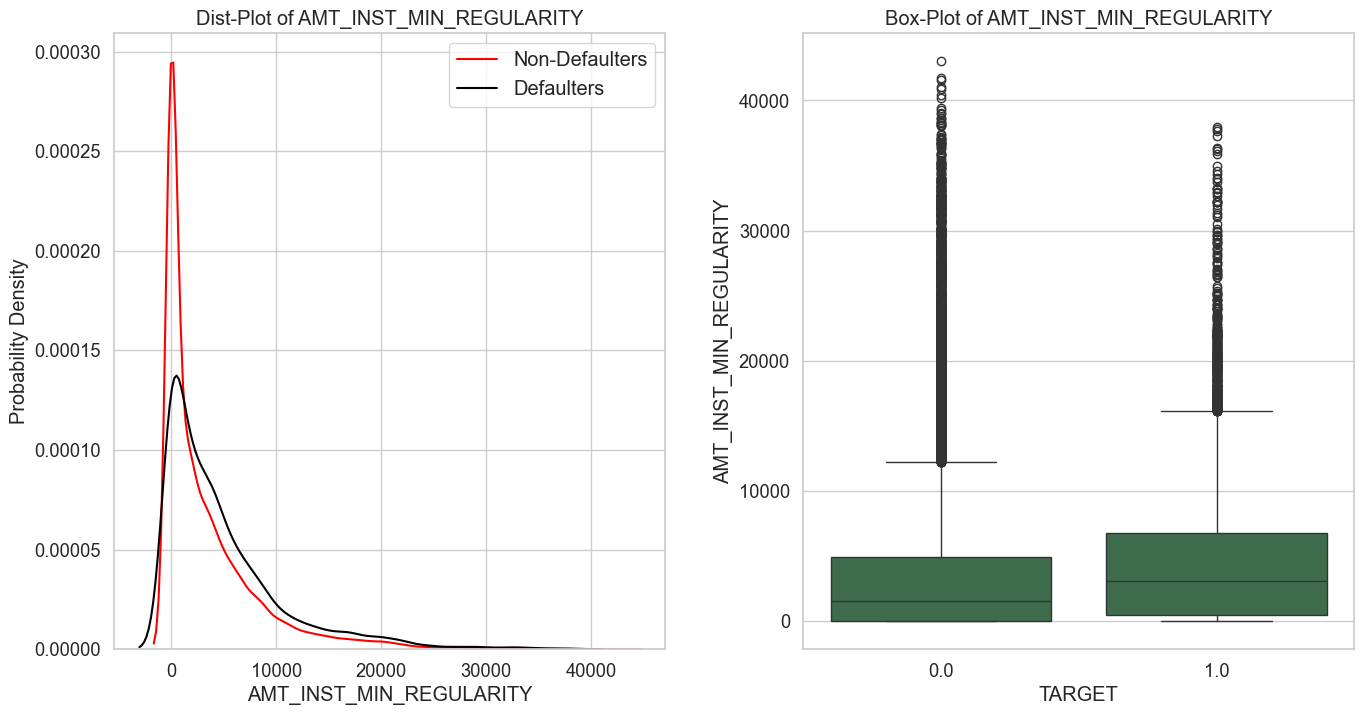

In [17]:
plot_continuous_variables(credit_mean, 'AMT_INST_MIN_REGULARITY', plots=['distplot', 'box'], figsize=(16, 8))

### Observation
- Defaulters show higher values of all the quantiles compared to non-defaulters.
- The PDF also shows a very higher peak at lower amounts for non-defaulters as compared to defaulters.

Therefore, we could conclude that the minimum installment of the previous credit for defaulters could be relatively higher than non-defaulters

## 10.4 MONTHS_BALANCE

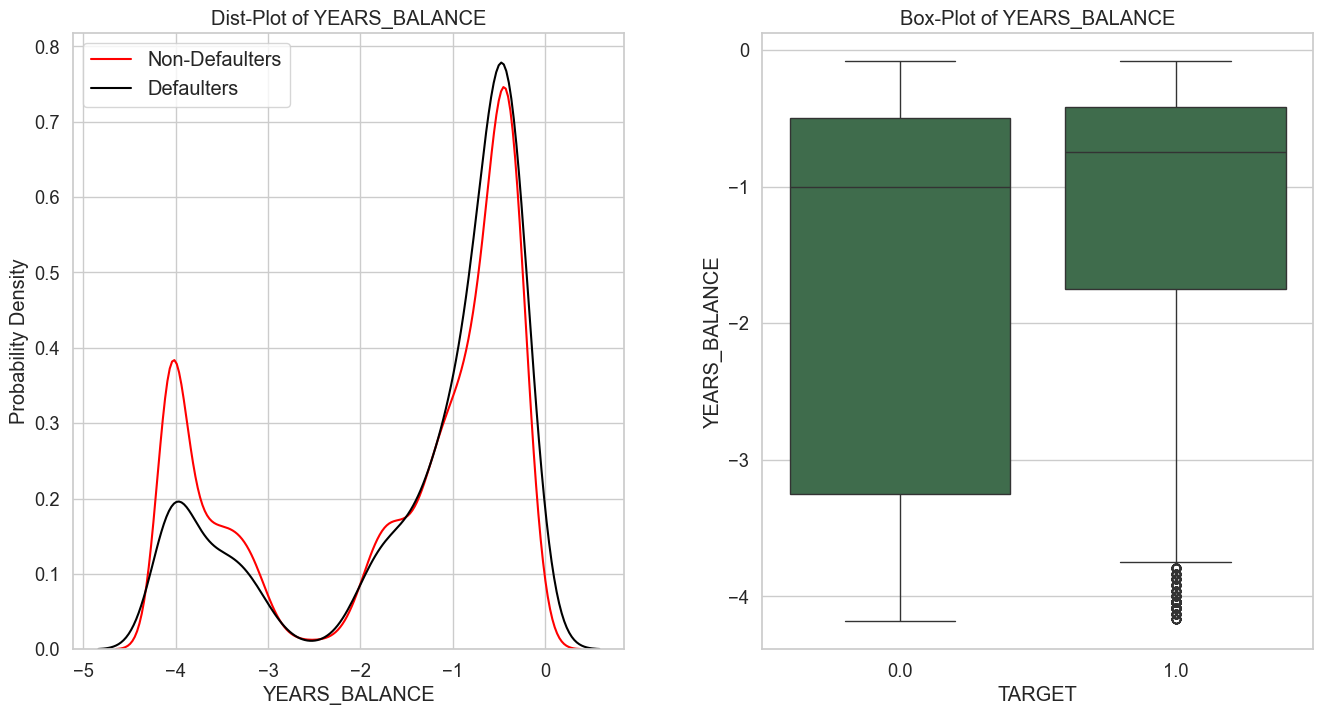

In [18]:
credit_mean['YEARS_BALANCE'] = credit_mean['MONTHS_BALANCE'] / 12
plot_continuous_variables(credit_mean, 'YEARS_BALANCE', plots=['distplot','box'])
credit_mean.drop('YEARS_BALANCE', axis=1, inplace=True)

### Observation
- Defaulters show higher values of all the quantiles compared to non-defaulters.

- The PDF has two distinct peaks. The first peak was observed roughly four years ago, while the second peak occurred approximately six months ago. During the first peak, the value of non-defaulters was higher. However, during the second peak, defaulters had a higher value. 

As the application date of the defaulter is closer to the current date than that of the non-defaulter, we can conclude that the defaulter applied more recently.